# Monte Carlo 

### Acrobot-V1

Load modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import time

import gym

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

Environment
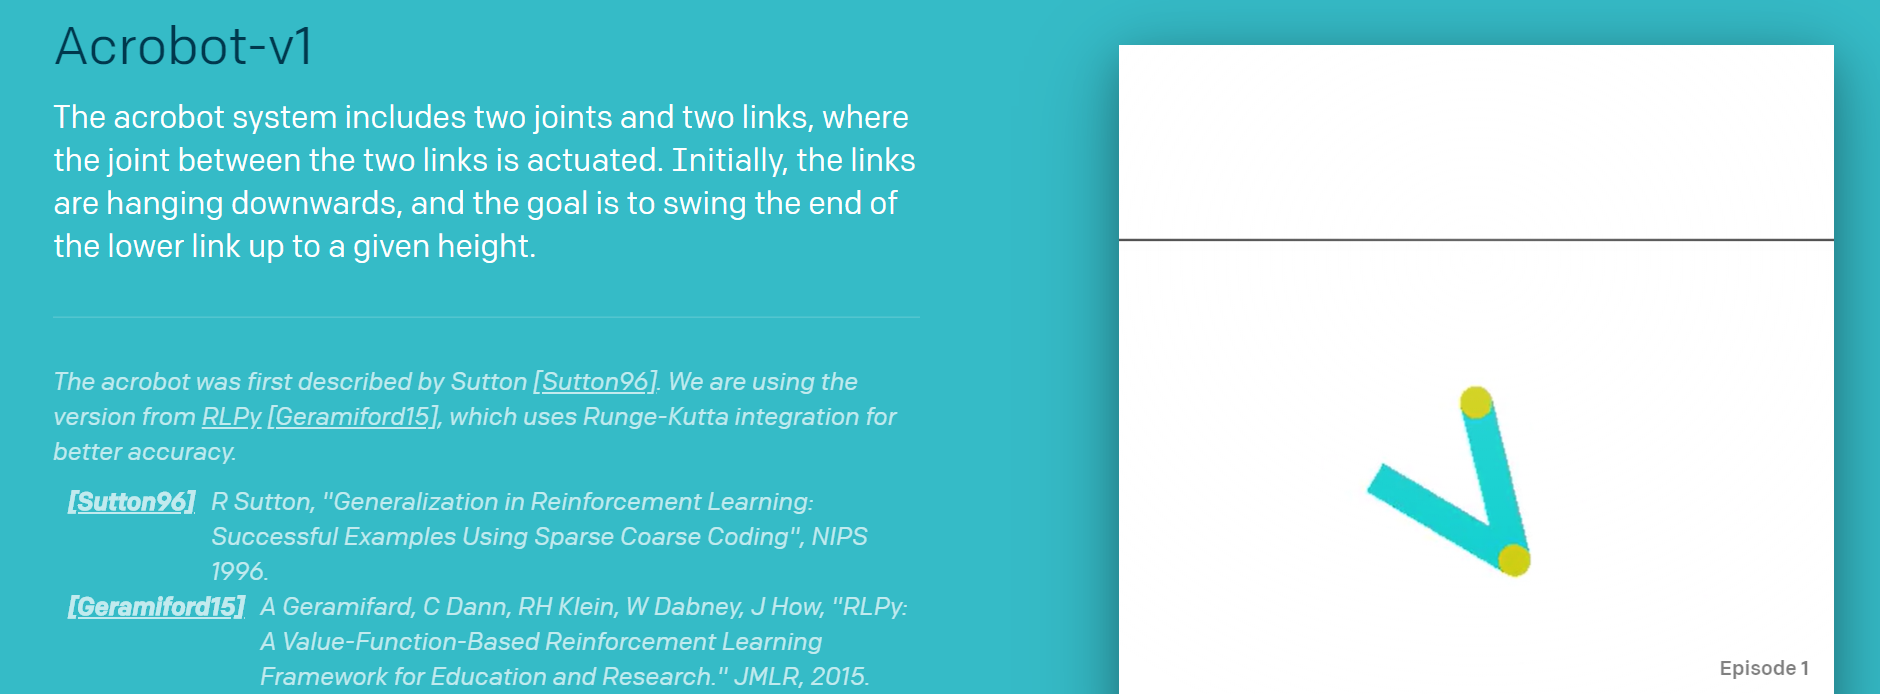

In [2]:
env = gym.make('Acrobot-v1')    # 환경설정
# 상태 공간과 행동공간 
print(f'Dimension of State Space : {len(env.observation_space.high)}')
print(f'The number of action : {env.action_space.n}')

Dimension of State Space : 6
The number of action : 3


### Acrobot

1) Model

- input dimmension : 6
- hidden dimmension : 128
- output dimmension : 3

2) Make epsiode

- make one episode

3) Update

- Update network

4) Training loop

- Make episode and update network repeatly
- Save model

5) Rendering

In [3]:
class Acrobot(nn.Module):
    def __init__(self, in_dim = 6, h_dim=128, out_dim = 3, lr = 1e-4, gamma = 0.9):
        super(Acrobot, self).__init__()
        self.env = gym.make('Acrobot-v1')
        self.episode = []          
        self.in_dim = in_dim
        self.h_dim = h_dim
        self.out_dim = out_dim
        self.fc1 = nn.Linear(self.in_dim, self.h_dim)      
        self.fc2 = nn.Linear(self.h_dim, self.out_dim)
        self.lr = lr
        self.gamma = gamma
        self.opt = optim.Adam(self.parameters(), lr=self.lr)
        self.losses = []
        self.scores = []
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=0)
        return x     
    
    def make_episode(self):
        self.episode = []
        state = self.env.reset()
        done = False
        score = 0
        while not done:  
            state = torch.from_numpy(state).float() 
            prob = self(state)
            action = Categorical(prob).sample().item()
            next_state, reward, done, info = self.env.step(action)
            self.episode.append([reward,prob[action]])
            state = next_state
            score += reward
        self.scores.append(score)
    
    def update(self):
        R = 0
        self.opt.zero_grad()
        for r, prob in self.episode[::-1]:
            R = r + self.gamma * R
            loss = -torch.log(prob) * R
            loss.backward()     
        self.opt.step()   
        self.losses.append(loss.detach().item())        
        
    def training_loop(self, n_episode, save = False):  
        self.losses = []
        self.scores = []
        for epi in range(n_episode):
            self.make_episode()
            self.update()
                     
            #------ Save -----#
            if save and epi > 500:
                # 이전 episode보다 score가 높고, loss가 작은 경우에 저장
                if self.scores[epi] > max(self.scores[:epi-1]): 
                    print(f'Epoch : {epi} / Loss : {self.losses[epi]} /  Score : {self.scores[epi]}')
                    torch.save({'model_state_dict' : self.state_dict(),
                               'opt_state_dict' : self.opt.state_dict(),
                               'episode' : epi}
                               , './Acrobat.pt')

                
    def rendering(self, repeat, max_time, sleep_time):  
      # 최대 max_time만틈 repeat횟수만큼 렌더링
        for _ in range(repeat):
            start_time = time.time()
            state = self.env.reset()
            done = False
            while not done:  
                self.env.render()
                state = torch.from_numpy(state).float()  # numpy ---> tensor
                prob = self(state)
                action = Categorical(prob).sample().item()
                next_state, reward, done, info = self.env.step(action)
                state = next_state
                time.sleep(sleep_time)
                if time.time() - start_time > max_time:
                    done = True 
        self.env.close()

Training

    Maximum Score is -246 (Minimum was -500)

In [4]:
if __name__ == "__main__":
    model = Acrobot()
    model.training_loop(n_episode = 5000, save = True)

Epoch : 831 / Loss : -12.653151512145996 /  Score : -269.0
Epoch : 842 / Loss : -12.052457809448242 /  Score : -267.0
Epoch : 998 / Loss : -11.647772789001465 /  Score : -259.0
Epoch : 1337 / Loss : -9.290765762329102 /  Score : -257.0
Epoch : 2414 / Loss : -8.943611145019531 /  Score : -246.0


Visualize

    Training was very unstable

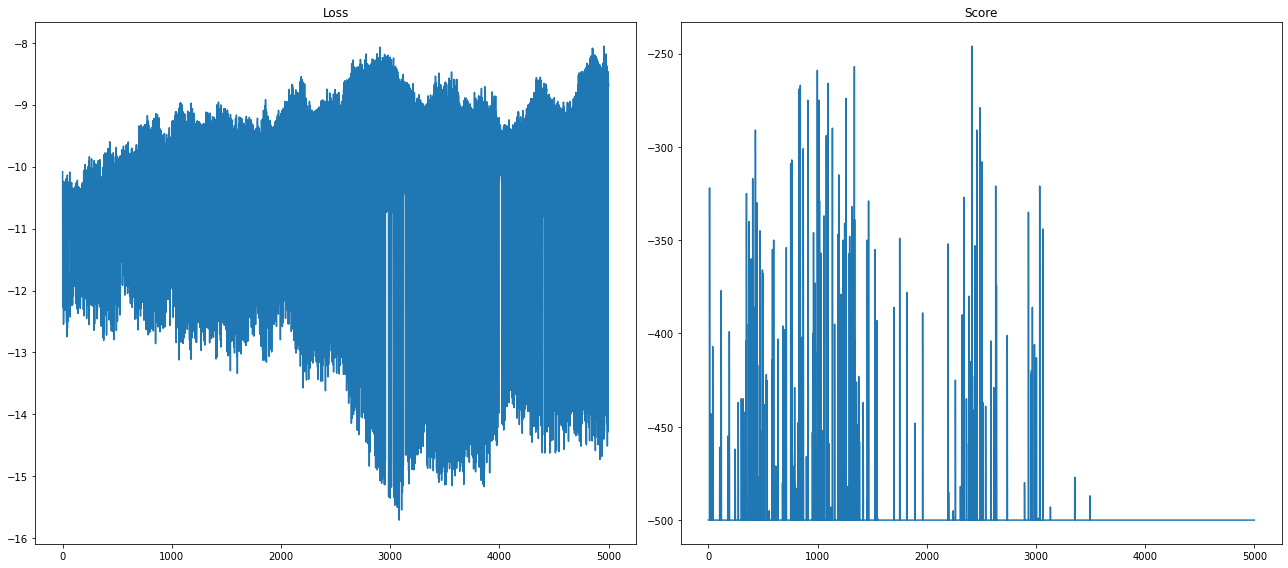

In [10]:
fig, ax = plt.subplots(1, 2, figsize = (18, 8))
ax[0].plot(model.losses)
ax[0].set_title('Loss')
ax[1].plot(model.scores)
ax[1].set_title('Score')
plt.tight_layout()
plt.show()